In [ ]:
!pip install causalnex networkx==2.5.1

In [ ]:
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.network import BayesianNetwork
from causalnex.inference import InferenceEngine

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer

from causalnex.structure import StructureModel
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
df = pd.read_csv('../data/cleaned_df.csv', )

In [ ]:
df.rename(columns={
    'Distance (Trip to Destination)': 'Distance_Trip_to_Destination',
    'Distance From Trip Origin': 'Distance_From_Trip_Origin',
    'lat': 'latitude',
    'lng': 'longitude'
}, inplace=True)

In [ ]:
le = LabelEncoder()

non_numeric_columns = list(df.select_dtypes(exclude = 'number').columns)

for col in non_numeric_columns:
  df[col] = le.fit_transform(df[col])

In [ ]:
df['driver_action'] = df['driver_action'].apply(lambda x: 0 if x == 1 else 1)

In [ ]:
# Discretize the continuous variables
discretizer_distance_origin = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
discretizer_distance_destination = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
discretizer_latitude = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
discretizer_longitude = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')


df['Distance_From_Trip_Origin'] = discretizer_distance_origin.fit_transform(df[['Distance_From_Trip_Origin']]).astype(int)
df['Distance_Trip_to_Destination'] = discretizer_distance_destination.fit_transform(df[['Distance_Trip_to_Destination']]).astype(int)
df['latitude'] = discretizer_latitude.fit_transform(df[['latitude']]).astype(int)
df['longitude'] = discretizer_longitude.fit_transform(df[['longitude']]).astype(int)


In [ ]:
cols = ['is_weekend', 'driver_action', 'latitude', 'longitude', 'Distance_From_Trip_Origin', 'Distance_Trip_to_Destination']

In [ ]:
from causalnex.inference import InferenceEngine
from causalnex.structure import DAGClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


# Define treatment variable (driver_action) and covariates
treatment = 'driver_action'
covariates = ['is_weekend', 'latitude', 'longitude', 'Distance_From_Trip_Origin', 'Distance_Trip_to_Destination']

# Split data into train and test sets
train, test = train_test_split(df[cols], test_size=0.2, random_state=42)

# Train a DAG (Directed Acyclic Graph) classifier to learn the causal structure
clf = DAGClassifier()
clf.fit(train[covariates], train[treatment])


DAGClassifier(target_dist_type='bin')

In [ ]:
sm = StructureModel()

driver_action_relations = [
    (col, 'driver_action') for col in cols if col != 'driver_action'
]

sm.add_edges_from(driver_action_relations)

In [ ]:
driver_action_relations

[('is_weekend', 'driver_action'),
 ('latitude', 'driver_action'),
 ('longitude', 'driver_action'),
 ('Distance_From_Trip_Origin', 'driver_action'),
 ('Distance_Trip_to_Destination', 'driver_action')]

In [ ]:
viz = plot_structure(sm,
                     all_node_attributes=NODE_STYLE.WEAK, all_edge_attributes=EDGE_STYLE.WEAK)
viz.show("causal_structure.html")

causal_structure.html


In [ ]:
from causalnex.inference import InferenceEngine
from causalnex.structure.notears import from_pandas
from causalnex.network import BayesianNetwork


# Create your Bayesian Network
bn = BayesianNetwork(sm)

# Fit the model
bn = bn.fit_node_states_and_cpds(train)

# Instantiate the inference engine
ie = InferenceEngine(bn)

In [ ]:
from causalnex.inference import InferenceEngine

marginals = ie.query({})

In [ ]:
marginals

{'is_weekend': {0: 0.8726667563497693, 1: 0.12733324365021595},
 'driver_action': {0: 0.9259156128562702, 1: 0.07408438714372964},
 'latitude': {0: 0.10491289370975616,
  1: 0.10088412472346694,
  2: 0.0807663166445787,
  3: 0.15736152950886648,
  4: 0.2387987290544357,
  5: 0.21276534807366443,
  6: 0.08487232829346668,
  7: 0.0180044835460111,
  8: 0.0015266274551667088,
  9: 0.00010761899058594099},
 'longitude': {0: 1.7357901707410013e-05,
  1: 0.0004495696542219168,
  2: 0.00959978753928311,
  3: 0.22976828069115598,
  4: 0.593003203400762,
  5: 0.09221819229604196,
  6: 0.06357678658373027,
  7: 0.010654280068008243,
  8: 0.0006648076353938016,
  9: 4.773422969537757e-05},
 'Distance_From_Trip_Origin': {0: 0.9129362366159726,
  1: 0.08687976962592878,
  2: 7.550687242723403e-05,
  3: 4.339475426852492e-05,
  4: 3.124422307333787e-05,
  5: 1.1282636109816501e-05,
  6: 9.54684593907553e-06,
  7: 3.471580341481998e-06,
  8: 3.471580341481998e-06,
  9: 6.0752655975934945e-06},
 'Dist

In [ ]:
for i in range(0,10):
  ie.do_intervention('Distance_From_Trip_Origin',i)
  print(f"predicted_outcome_{i} = {ie.query()['driver_action']}")

  ie.reset_do("Distance_From_Trip_Origin")

predicted_outcome_0 = {0: 0.9261506621157314, 1: 0.0738493378842675}
predicted_outcome_1 = {0: 0.9241908352004339, 1: 0.07580916479956479}
predicted_outcome_2 = {0: 0.6010546511938518, 1: 0.3989453488061478}
predicted_outcome_3 = {0: 0.6004650757802602, 1: 0.39953492421973946}
predicted_outcome_4 = {0: 0.5474766397258937, 1: 0.45252336027410645}
predicted_outcome_5 = {0: 0.5086021685487234, 1: 0.4913978314512775}
predicted_outcome_6 = {0: 0.5060975283004194, 1: 0.4939024716995813}
predicted_outcome_7 = {0: 0.5000278222426934, 1: 0.4999721777573065}
predicted_outcome_8 = {0: 0.5001340968744853, 1: 0.49986590312551393}
predicted_outcome_9 = {0: 0.49998933586049815, 1: 0.5000106641395018}


In [ ]:
for i in range(0,10):
  ie.do_intervention('Distance_Trip_to_Destination',i)
  print(f"predicted_outcome_{i} = {ie.query()['driver_action']}")

  ie.reset_do("Distance_Trip_to_Destination")

predicted_outcome_0 = {0: 0.9294592618096897, 1: 0.0705407381903082}
predicted_outcome_1 = {0: 0.9261657614216852, 1: 0.07383423857831489}
predicted_outcome_2 = {0: 0.9187596382173567, 1: 0.08124036178264367}
predicted_outcome_3 = {0: 0.8978751945118882, 1: 0.10212480548811144}
predicted_outcome_4 = {0: 0.870340017064868, 1: 0.12965998293513195}
predicted_outcome_5 = {0: 0.7794153424698222, 1: 0.22058465753017753}
predicted_outcome_6 = {0: 0.7102473795443714, 1: 0.2897526204556265}
predicted_outcome_7 = {0: 0.5777774081450692, 1: 0.4222225918549283}
predicted_outcome_8 = {0: 0.5467010800843203, 1: 0.4532989199156771}
predicted_outcome_9 = {0: 0.6017512448476531, 1: 0.3982487551523446}


In [ ]:
for i in range(0,10):
  ie.do_intervention('latitude',i)
  print(f"predicted_outcome_{i} = {ie.query()['driver_action']}")

  ie.reset_do("latitude")

predicted_outcome_0 = {0: 0.8807954545124166, 1: 0.11920454548758222}
predicted_outcome_1 = {0: 0.9738453481666256, 1: 0.026154651833373732}
predicted_outcome_2 = {0: 0.9018269947953806, 1: 0.09817300520461844}
predicted_outcome_3 = {0: 0.9071460813046821, 1: 0.09285391869531655}
predicted_outcome_4 = {0: 0.9125743513752328, 1: 0.08742564862476547}
predicted_outcome_5 = {0: 0.9569955881518631, 1: 0.0430044118481358}
predicted_outcome_6 = {0: 0.9461897466764555, 1: 0.053810253323542896}
predicted_outcome_7 = {0: 0.9201569709898703, 1: 0.07984302901012834}
predicted_outcome_8 = {0: 0.7887495483393151, 1: 0.21125045166068349}
predicted_outcome_9 = {0: 0.5820410206077477, 1: 0.4179589793922511}


In [ ]:
for i in range(0,10):
  ie.do_intervention('longitude',i)
  print(f"predicted_outcome_{i} = {ie.query()['driver_action']}")

  ie.reset_do("longitude")

predicted_outcome_0 = {0: 0.4980029049681065, 1: 0.5019970950318928}
predicted_outcome_1 = {0: 0.5745188256580477, 1: 0.4254811743419519}
predicted_outcome_2 = {0: 0.8796279260937263, 1: 0.12037207390627268}
predicted_outcome_3 = {0: 0.934117147310038, 1: 0.0658828526899617}
predicted_outcome_4 = {0: 0.9844214110874978, 1: 0.015578588912502205}
predicted_outcome_5 = {0: 0.7156217213855008, 1: 0.2843782786144986}
predicted_outcome_6 = {0: 0.7115226191596633, 1: 0.28847738084033675}
predicted_outcome_7 = {0: 0.6735035892983846, 1: 0.32649641070161556}
predicted_outcome_8 = {0: 0.5703660978272208, 1: 0.4296339021727788}
predicted_outcome_9 = {0: 0.5102656633061121, 1: 0.489734336693887}


In [ ]:
for i in range(0,2):
  ie.do_intervention('is_weekend',i)
  print(f"predicted_outcome_{i} = {ie.query()['driver_action']}")

  ie.reset_do("is_weekend")

predicted_outcome_0 = {0: 0.5862717893288426, 1: 0.41372821067115706}
predicted_outcome_1 = {0: 0.49397096250721195, 1: 0.5060290374927878}


In [ ]:
bin_edges = discretizer_longitude.bin_edges_[0]

In [ ]:
discrete_value = 9

# The original range for the given discrete value (bin)
original_range = (bin_edges[discrete_value], bin_edges[discrete_value + 1])

print(f"Drivers around {original_range} location tends to accepts a lot comparing to the others.")

Drivers around (3.67677456, 3.7425233) location tends to accepts a lot comparing to the others.


In [ ]:
import networkx as nx

nx.drawing.nx_pydot.write_dot(sm, 'graph.dot')

In [ ]:
cpd_data = bn.cpds['driver_action'].T

# Convert the CPD data to a DataFrame
df_cpd = pd.DataFrame(cpd_data)

# Adding column names for readability
df_cpd.columns = ['prob_driver_action_0', 'prob_driver_action_1']


parent_vars = ['is_weekend', 'latitude', 'longitude', 'Distance_From_Trip_Origin', 'Distance_Trip_to_Destination']

# Extracting parent variable values
df_cpd[parent_vars] = pd.DataFrame(cpd_data.index.tolist(), index=df_cpd.index)

# Reorder columns to place parent variables first
df_cpd = df_cpd[parent_vars + ['prob_driver_action_0', 'prob_driver_action_1']]


df_cpd.reset_index(drop=True, inplace=True)

In [ ]:
df_cpd

,longitude,latitude,is_weekend,Distance_From_Trip_Origin,Distance_Trip_to_Destination,prob_driver_action_0,prob_driver_action_1
0,0,0,0,0,0,0.500000,0.500000
1,0,0,0,0,1,0.500000,0.500000
2,0,0,0,0,2,0.500000,0.500000
3,0,0,0,0,3,0.666667,0.333333
4,0,0,0,0,4,0.988642,0.011358
...,...,...,...,...,...,...,...
19995,9,9,1,9,5,0.500000,0.500000
19996,9,9,1,9,6,0.500000,0.500000
19997,9,9,1,9,7,0.500000,0.500000
19998,9,9,1,9,8,0.500000,0.500000


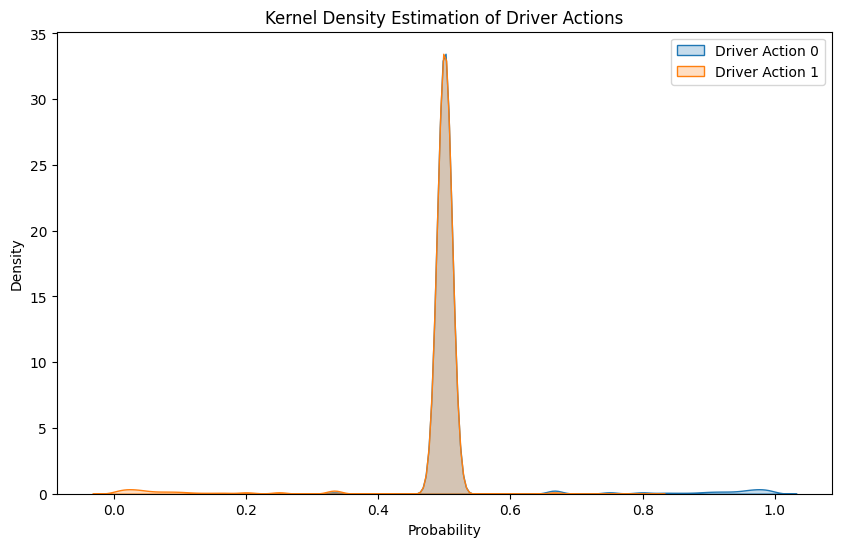

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_cpd, x='prob_driver_action_0', label='Driver Action 0', shade=True)
sns.kdeplot(data=df_cpd, x='prob_driver_action_1', label='Driver Action 1', shade=True)
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of Driver Actions')
plt.legend()
plt.show()


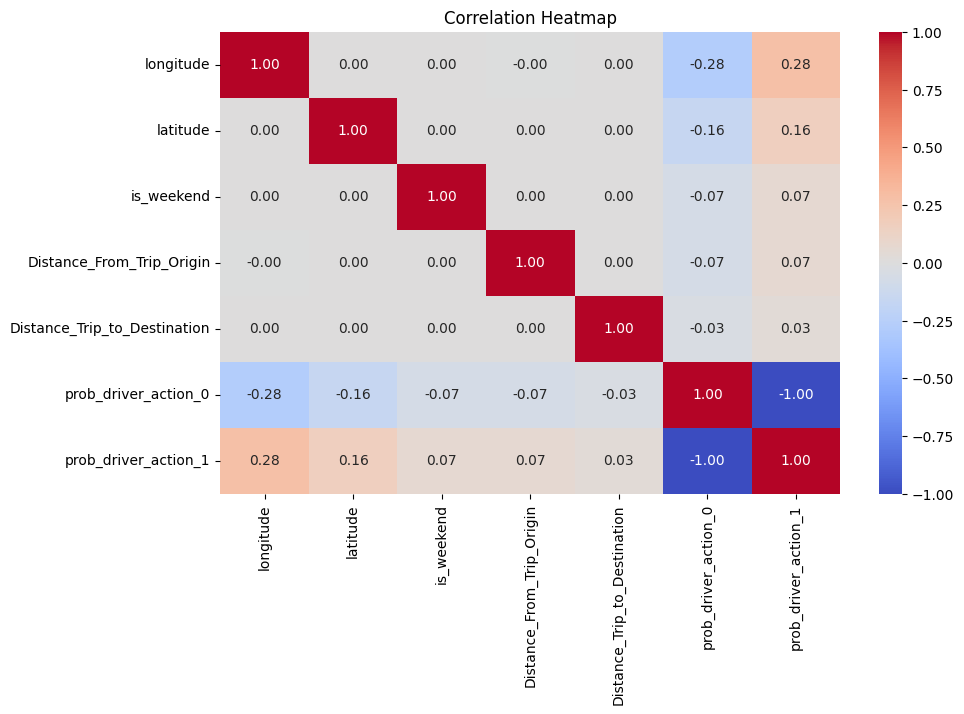

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_cpd.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

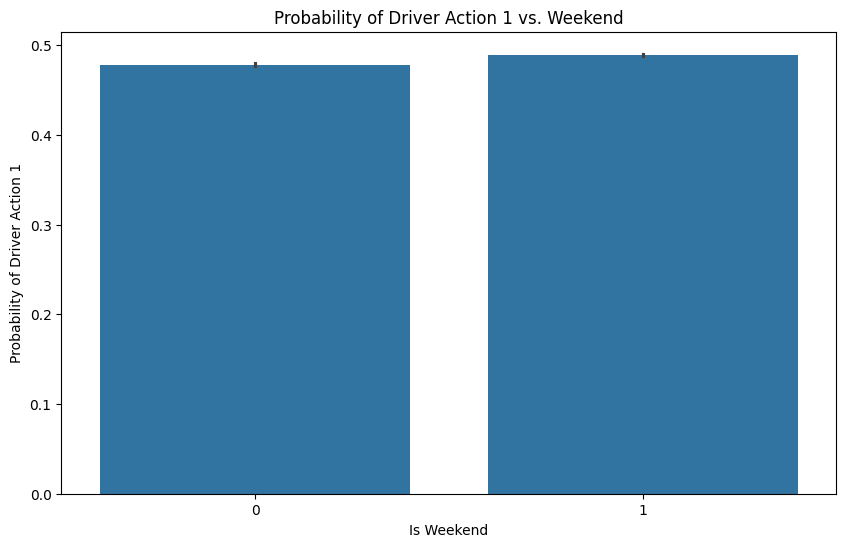

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='is_weekend', y='prob_driver_action_1', data=df_cpd)
plt.title('Probability of Driver Action 1 vs. Weekend')
plt.xlabel('Is Weekend')
plt.ylabel('Probability of Driver Action 1')
plt.show()

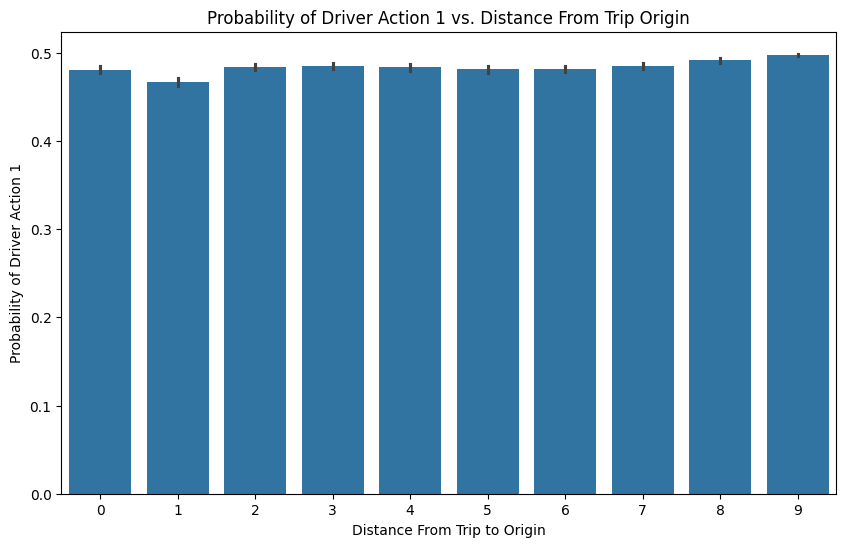

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Distance_From_Trip_Origin', y='prob_driver_action_1', data=df_cpd)
plt.title('Probability of Driver Action 1 vs. Distance From Trip Origin')
plt.xlabel('Distance From Trip to Origin')
plt.ylabel('Probability of Driver Action 1')
plt.show()

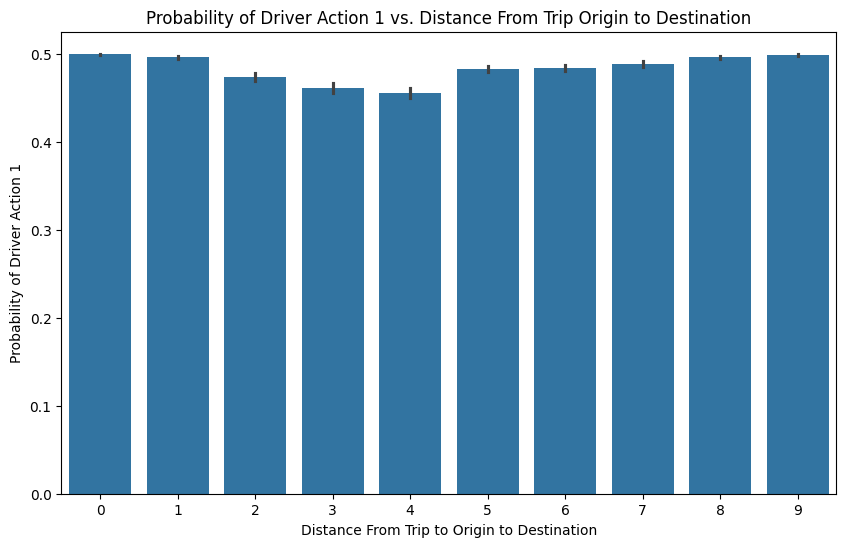

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Distance_Trip_to_Destination', y='prob_driver_action_1', data=df_cpd)
plt.title('Probability of Driver Action 1 vs. Distance From Trip Origin to Destination')
plt.xlabel('Distance From Trip to Origin to Destination')
plt.ylabel('Probability of Driver Action 1')
plt.show()